In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

2025-11-16 07:56:39.375407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763279799.845892      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763279799.957569      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train_dir = '/kaggle/input/dataset-lab4-mobilenet/seg'
test_dir = '/kaggle/input/dataset-lab4-mobilenet/seg_test'

In [3]:
img_height, img_width = 224, 224
batch_size = 8  
epochs = 30
num_classes = 6

In [4]:
# Data preprocessing với augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=True,
    validation_split=0.2  # 20% cho validation
)

# Chỉ rescale cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Số lượng classes: {train_generator.num_classes}")
print(f"Classes: {train_generator.class_indices}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Số lượng classes: 6
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
# Xây dựng model MobileNetV2
def build_mobilenet_model():
    # Load MobileNetV2 pretrained trên ImageNet
    print("Loading MobileNetV2 pretrained weights...")
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )
    print("MobileNetV2 base model loaded!")
    
    # Đóng băng các layers của base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Thêm các layers tùy chỉnh - MobileNetV2
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Tạo model hoàn chỉnh
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [6]:
# Tạo model
model = build_mobilenet_model()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Loading MobileNetV2 pretrained weights...


I0000 00:00:1763279833.431508      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763279833.432237      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model loaded!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,179,590 (12.13 MB)

 Trainable params: 921,606 (3.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Callbacks
checkpoint = ModelCheckpoint(
    'models/mobilenet_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
os.makedirs('models', exist_ok=True)
print("\nModels directory ready.")


Models directory ready.


In [9]:
print("\n========== BẮT ĐẦU TRAINING MOBILENETV2 ==========\n")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Lưu model cuối cùng
model.save('models/mobilenet_final.h5')


========== BẮT ĐẦU TRAINING MOBILENETV2 ==========



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763279842.009224     132 service.cc:148] XLA service 0x7e0b90004420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763279842.010886     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763279842.010910     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763279842.981367     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1404 ━━━━━━━━━━━━━━━━━━━━ 1:38 70ms/step - accuracy: 0.0972 - loss: 2.3650      

I0000 00:00:1763279847.996805     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6925 - loss: 0.7953
Epoch 1: val_accuracy improved from -inf to 0.86698, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 231s 157ms/step - accuracy: 0.6925 - loss: 0.7951 - val_accuracy: 0.8670 - val_loss: 0.3550 - learning_rate: 1.0000e-04
Epoch 2/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8465 - loss: 0.4128
Epoch 2: val_accuracy improved from 0.86698 to 0.87981, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 163s 116ms/step - accuracy: 0.8465 - loss: 0.4128 - val_accuracy: 0.8798 - val_loss: 0.3315 - learning_rate: 1.0000e-04
Epoch 3/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8630 - loss: 0.3727
Epoch 3: val_accuracy did not improve from 0.87981
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 116ms/step - accuracy: 0.8630 - loss: 0.3727 - val_accuracy: 0.8795 - val_loss: 0.3246 - learning_rate: 1.0000e-04
Epoch 4/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8709 - loss: 0.3512
Epoch 4: val_accuracy improved from 0.87981 to 0.88053, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 164s 117ms/step - accuracy: 0.8709 - loss: 0.3512 - val_accuracy: 0.8805 - val_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 5/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8832 - loss: 0.3198
Epoch 5: val_accuracy improved from 0.88053 to 0.88124, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 164s 116ms/step - accuracy: 0.8832 - loss: 0.3199 - val_accuracy: 0.8812 - val_loss: 0.3180 - learning_rate: 1.0000e-04
Epoch 6/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8767 - loss: 0.3331
Epoch 6: val_accuracy did not improve from 0.88124
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 164s 117ms/step - accuracy: 0.8768 - loss: 0.3331 - val_accuracy: 0.8766 - val_loss: 0.3416 - learning_rate: 1.0000e-04
Epoch 7/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8792 - loss: 0.3177
Epoch 7: val_accuracy improved from 0.88124 to 0.88516, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 163s 116ms/step - accuracy: 0.8792 - loss: 0.3177 - val_accuracy: 0.8852 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 8/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8867 - loss: 0.3002
Epoch 8: val_accuracy improved from 0.88516 to 0.89479, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 164s 116ms/step - accuracy: 0.8867 - loss: 0.3002 - val_accuracy: 0.8948 - val_loss: 0.3045 - learning_rate: 1.0000e-04
Epoch 9/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8904 - loss: 0.2898
Epoch 9: val_accuracy did not improve from 0.89479
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 115ms/step - accuracy: 0.8904 - loss: 0.2898 - val_accuracy: 0.8916 - val_loss: 0.2914 - learning_rate: 1.0000e-04
Epoch 10/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8888 - loss: 0.2881
Epoch 10: val_accuracy did not improve from 0.89479
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 163s 116ms/step - accuracy: 0.8888 - loss: 0.2881 - val_accuracy: 0.8866 - val_loss: 0.2969 - learning_rate: 1.0000e-04
Epoch 11/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8978 - loss: 0.2731
Epoch 11: val_accuracy did not improve from 0.89479
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 116ms/step - accuracy: 0.8978 - loss: 0.2731 - val_accuracy: 0.8887 - val_loss: 0.2988 

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 115ms/step - accuracy: 0.9042 - loss: 0.2534 - val_accuracy: 0.8955 - val_loss: 0.2766 - learning_rate: 5.0000e-05
Epoch 16/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9048 - loss: 0.2428
Epoch 16: val_accuracy improved from 0.89551 to 0.90193, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 116ms/step - accuracy: 0.9048 - loss: 0.2428 - val_accuracy: 0.9019 - val_loss: 0.2862 - learning_rate: 5.0000e-05
Epoch 17/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9034 - loss: 0.2664
Epoch 17: val_accuracy improved from 0.90193 to 0.90264, saving model to models/mobilenet_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 163s 116ms/step - accuracy: 0.9034 - loss: 0.2664 - val_accuracy: 0.9026 - val_loss: 0.2760 - learning_rate: 5.0000e-05
Epoch 18/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9099 - loss: 0.2370
Epoch 18: val_accuracy did not improve from 0.90264
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 166s 118ms/step - accuracy: 0.9099 - loss: 0.2370 - val_accuracy: 0.8973 - val_loss: 0.2870 - learning_rate: 5.0000e-05
Epoch 19/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9121 - loss: 0.2315
Epoch 19: val_accuracy did not improve from 0.90264
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 115ms/step - accuracy: 0.9121 - loss: 0.2315 - val_accuracy: 0.8944 - val_loss: 0.2836 - learning_rate: 5.0000e-05
Epoch 20/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9113 - loss: 0.2334
Epoch 20: val_accuracy did not improve from 0.90264
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 165s 117ms/step - accuracy: 0.9113 - loss: 0.2334 - val_accuracy: 0.8976 - val_loss: 0.290

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 164s 117ms/step - accuracy: 0.9148 - loss: 0.2199 - val_accuracy: 0.9037 - val_loss: 0.2781 - learning_rate: 2.5000e-05
Epoch 28/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9262 - loss: 0.2009
Epoch 28: val_accuracy did not improve from 0.90371
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 167s 119ms/step - accuracy: 0.9262 - loss: 0.2009 - val_accuracy: 0.9034 - val_loss: 0.2737 - learning_rate: 2.5000e-05
Epoch 29/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9200 - loss: 0.2068
Epoch 29: val_accuracy did not improve from 0.90371
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 163s 116ms/step - accuracy: 0.9200 - loss: 0.2068 - val_accuracy: 0.8998 - val_loss: 0.2911 - learning_rate: 2.5000e-05
Epoch 30/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9278 - loss: 0.1899
Epoch 30: val_accuracy did not improve from 0.90371
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 162s 115ms/step - accuracy: 0.9278 - loss: 0.1899 - val_accuracy: 0.8962 - val_loss: 0.296

In [10]:
print("\n========== ĐÁNH GIÁ TRÊN TẬP TEST ==========\n")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



========== ĐÁNH GIÁ TRÊN TẬP TEST ==========

375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.9175 - loss: 0.2141
Test Loss: 0.2316
Test Accuracy: 0.9150


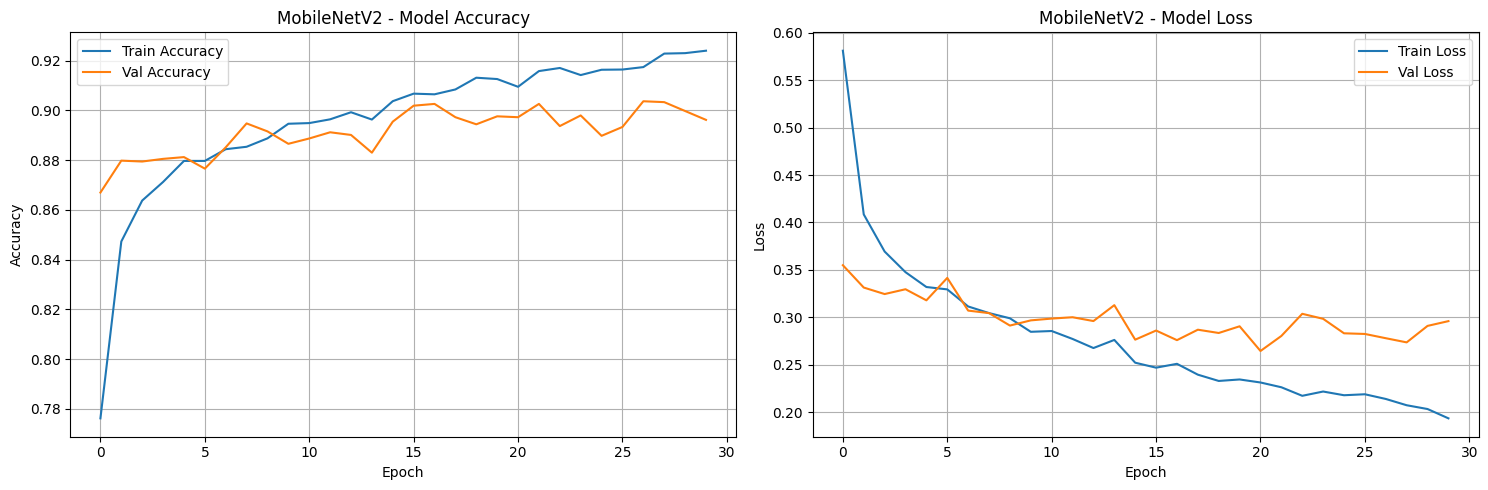

In [11]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('MobileNetV2 - Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('MobileNetV2 - Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('results/mobilenet_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Tạo thư mục results
os.makedirs('results', exist_ok=True)

# Vẽ biểu đồ
plot_training_history(history)
